- General Idea: 
    - "Meaning" of a word can be captured by its nearby words (You shall know a word by the company it keeps)

# Co-occurence matrix
- Correlation of words is captured by how often the two words are "close" to each other
- Hyperparameter: window-size, weighting by distance to center of word.

References:
- https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html

In [77]:
import nltk
nltk.download('reuters')
from nltk.corpus import reuters

import pprint
from collections import defaultdict

import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD


[nltk_data] Downloading package reuters to /Users/soarer/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [78]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'

In [7]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [16]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[0], compact=True, width=100)

['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
 'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
 'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
 'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
 'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
 'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
 '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
 'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
 'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
 'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
 'energy', 'supply', '/', 'de

In [27]:
def get_vocabs():
    vocab_set = set()
    for corpus in reuters_corpus:
        vocab_set.update(corpus)
    
    return list(vocab_set)

In [29]:
_VOCAB_LIST = get_vocabs()
_VOCAB_TO_ID = {
    vocab: idx
    for idx, vocab in enumerate(_VOCAB_LIST)
}
len(_VOCAB_LIST)

8185

In [79]:
def get_frequencies():
    ret = defaultdict(int)
    for corpus in reuters_corpus:
        for word in corpus:
            ret[_VOCAB_TO_ID[word]] += 1
    
    return ret

In [80]:
_VOCAB_ID_TO_FREQ = get_frequencies()
N_TOTAL_FREQ = sum(_VOCAB_ID_TO_FREQ.values())

In [44]:
def get_co_occurence_matrix(window_size=4, skip_self_co_occurence=True):
    n_vocab = len(_VOCAB_LIST)
    ret = np.zeros((n_vocab, n_vocab))
    
    for corpus in reuters_corpus:
        cor_length = len(corpus)
        
        for idx, word in enumerate(corpus):
            for step in range(-window_size, window_size + 1):
                if idx + step < 0 or idx + step >= cor_length:
                    continue
                
                if skip_self_co_occurence and step == 0:
                    continue
                    
                vocab_idx_i = _VOCAB_TO_ID[word]
                vocab_idx_j = _VOCAB_TO_ID[corpus[idx + step]]
                
                ret[vocab_idx_i, vocab_idx_j] += 1
                ret[vocab_idx_j, vocab_idx_i] += 1
                
    return ret

In [45]:
co_occurence_matrix = get_co_occurence_matrix()

In [46]:
# next steps
# - do svd; figure out meaning of explained variance; check cutoff
# - check sample words/highest dot product after projection
# - do more low dim projection (t-SNE? UMAP?) to see word clusters

In [48]:
# a few sample words: building, borrowers, late, new
for word in ["building", "borrowers", "late", "new"]:
    vocab_idx = _VOCAB_TO_ID[word]
    
    co_occurence_vector = co_occurence_matrix[vocab_idx]
    highest_co_occurence_ids = sorted(
        list(np.argpartition(co_occurence_vector, -5)[-5:]),
        key=lambda idx: co_occurence_vector[idx], 
        reverse=True
    )
    highest_co_occured_words = [
        _VOCAB_LIST[idx] for idx in highest_co_occurence_ids
    ]
    print(f"Word: {word}")
    print("Highest co-occured words:")
    print(", ".join(
        [
            f"{word} (freq: {co_occurence_vector[idx]})" 
            for idx, word 
            in list(
                zip(highest_co_occurence_ids, highest_co_occured_words)
            )
        ]
    ))
    print("------")

Word: building
Highest co-occured words:
of (freq: 12.0), and (freq: 6.0), products (freq: 6.0), is (freq: 4.0), stock (freq: 4.0)
------
Word: borrowers
Highest co-occured words:
oil (freq: 4.0), banks (freq: 2.0), back (freq: 2.0), defaults (freq: 2.0), because (freq: 2.0)
------
Word: late
Highest co-occured words:
in (freq: 22.0), . (freq: 16.0), to (freq: 16.0), , (freq: 16.0), year (freq: 10.0)
------
Word: new
Highest co-occured words:
the (freq: 220.0), . (freq: 158.0), a (freq: 92.0), , (freq: 88.0), in (freq: 84.0)
------


In [50]:
# Projections to lower dimensions by PCA

def pca_get_low_dim_embeddings(matrix, k=2):
    svd = TruncatedSVD(n_components=k, n_iter=50, random_state=42)
    
    # from https://scikit-learn.org/stable/modules/decomposition.html#lsa
    # if X = UDV^T, the transformed embeddings is considered UD here
    # Don't think the scaling factor D matters - true thing that matters is the matrix/approximation (say UD_k V^T) itself.
    # e.g. in WALS, key point is the dot products approximate your matrix, and inference are made based on the dot products, not individual embeddings.
    return svd.fit_transform(matrix)

In [56]:
def pca_plot_explained_variance(matrix, k=50):
    svd = TruncatedSVD(n_components=k, n_iter=50, random_state=42)
    svd.fit(matrix)
    
    explained_variance_p_cum = np.cumsum(svd.explained_variance_ratio_) / np.sum(svd.explained_variance_ratio_)
    
    plt.plot(
        np.array(range(1, len(explained_variance_p_cum) + 1)),
        explained_variance_p_cum
    )
    plt.title("Explained variance from PCA of matrix")
    plt.xlabel("First k singular values")
    plt.ylabel("Cumulative proportion of explained variance")
    plt.show()

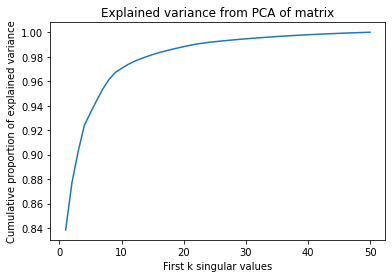

In [57]:
pca_plot_explained_variance(co_occurence_matrix)

In [71]:
def plot_2d_embeddings(labels, embeddings, scale=1, most_freq_sample=100):
    if most_freq_sample > 0:
        sample_indices = [idx for idx, cnt in sorted(_VOCAB_ID_TO_FREQ.items(), key=lambda item: item[1])[:most_freq_sample]]
        labels = labels[sample_indices]
        embeddings = embeddings[sample_indices]
        
    for label, embedding in zip(labels, embeddings):
        x, y = embedding[0] * scale, embedding[1] * scale
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x + 0.3, y +0.3, label, fontsize=9)
    plt.show()

In [72]:
embeddings = pca_get_low_dim_embeddings(co_occurence_matrix, k=2)

In [73]:
embeddings.shape

(8185, 2)

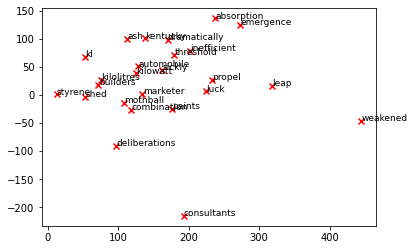

In [84]:
plot_2d_embeddings(
    np.array(_VOCAB_LIST), 
    embeddings,
    scale=100,
    most_freq_sample=25
)

### Overall feelings

- Quality of co-occurence matrix feels suspect itself (the highest co-occured words feel okay but not super good). Maybe need larger corpus/more cleaning of text beforehand.
- Embeddings thus obtained also feels suspect as a result; it's not clear how to check that though.
    - Visualization is not obvious (Perhaps most vectors have small length)
    - Dot product of embedding should proxy co-occurence, so should reflect correlation of two words. It may be necessary to formalize a list of benchmarking tasks.

Some complaints of getting embeddings this way:
- Co-occurence matrix is noisy
    - Overweights words that occur more often.
    - *Fix*: tfidf of some form
- Embedding is not canonical
    - Presumably true for any matrix factorization methods if dot product is the key. May be not a key point here.
- Error of embedding is not Gaussian
    - SVD/WALS style of matrix factorization assumes $L^2$-error, but as entries of co-occurence matrix don't live in the same scale, this effectively means embeddings are biased towards fitting words that co-occur the most, disproportinately.
    - *Fix 1*: change model - e.g. if co-occurence shouldn't be approximated by dot product + Gaussian error; maybe instead should be approximated by a Poisson variable that depends on dot product.
    - *Fix 2*: change matrix - sample idea: instead of co-occurence, normalize by likelihood of co-occurence, e.g. PPMI